# CRM Sales Opportunities

An example of ETA analysis using PostGreSQL with various joins, common table expressions, window functions and subqueries.
Follow-up visualizations were done in Python's matplotlib and seaborn.

### Dataset

The dataset used is _CRM Sales Opportunities_ obtained from [MavenAnalytics](https://www.mavenanalytics.io) - B2B sales pipeline data from a fictitious company that sells computer hardware, including information on accounts, products, sales teams, and sales opportunities. The dataset contains of four main data tables (saved in csv format), and an  _data_dictionary_ table.

## EXPLORATORY QUERIES
### Structure of tables 
The first few rows of each table are shown below:

In [33]:
SELECT * FROM sales_pipeline.csv LIMIT 5;

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20 00:00:00+00:00,2017-03-01 00:00:00+00:00,1054
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25 00:00:00+00:00,2017-03-11 00:00:00+00:00,4514
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25 00:00:00+00:00,2017-03-07 00:00:00+00:00,50
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25 00:00:00+00:00,2017-03-09 00:00:00+00:00,588
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25 00:00:00+00:00,2017-03-02 00:00:00+00:00,517


In [34]:
SELECT * FROM accounts.csv LIMIT 5;

,account,sector,year_established,revenue,employees,office_location,subsidiary_of
0,Acme Corporation,technolgy,1996,1100.04,2822,United States,None
1,Betasoloin,medical,1999,251.41,495,United States,None
2,Betatech,medical,1986,647.18,1185,Kenya,None
3,Bioholding,medical,2012,587.34,1356,Philipines,None
4,Bioplex,medical,1991,326.82,1016,United States,None


In [35]:
SELECT * FROM products.csv LIMIT 5;

,product,series,sales_price
0,GTX Basic,GTX,550
1,GTX Pro,GTX,4821
2,MG Special,MG,55
3,MG Advanced,MG,3393
4,GTX Plus Pro,GTX,5482


In [36]:
SELECT * FROM sales_teams.csv LIMIT 5;

,sales_agent,manager,regional_office
0,Anna Snelling,Dustin Brinkmann,Central
1,Cecily Lampkin,Dustin Brinkmann,Central
2,Versie Hillebrand,Dustin Brinkmann,Central
3,Lajuana Vencill,Dustin Brinkmann,Central
4,Moses Frase,Dustin Brinkmann,Central


Table _sales_pipeline_ will be used as the fact table. Tables _accounts_, _products_ and _sales_teams_ will be the dimension tables. The fields **acount**, **product** and **sales_agent** respectively as the key fields.

### Range of sale dates
It should be checked if any of the sales agents had joined/left the organization throughtout the year, as it would limit how their efficiency can be calculated. I use a subquery to find the first and last date for each agent, from which I get the minimum and maximum value of first and last dates.

In [37]:
SELECT 
	MIN(first_date) AS min_start_date,
	MAX(first_date) AS max_start_date,
	MIN(last_date) AS min_end_date,
	MAX(last_date) AS max_end_date
FROM 
	(SELECT 
		sales_agent, 
		MIN(close_date) AS first_date, 
		MAX(close_date) AS last_date
	FROM sales_pipeline.csv
	GROUP BY sales_agent) AS subquery;

,min_start_date,max_start_date,min_end_date,max_end_date
0,2017-03-01 00:00:00+00:00,2017-03-10 00:00:00+00:00,2017-12-25 00:00:00+00:00,2017-12-31 00:00:00+00:00


For every sales agent appearing in the _sales_pipeline_ table, the time frame begins between 2017-03-01 and 2017-03-10, and ends between 2017-12-25 and 2017-12-31. 
Therefore all the agents (and consequently, sales teams and regional offices) were active roughly throughout the analyzed time frame.

### Field matches: product
The _product_ field will be used as key value for performing table joining. I use a query to check if values match between _products_ and _sales_pipelines_ tables:

In [38]:
SELECT 
	DISTINCT p.product AS Products_table_names, 
	sp.product AS SalesPipeline_table_names 
FROM products.csv AS p
FULL JOIN sales_pipeline.csv AS sp
ON p.product = sp.product
WHERE Products_table_names IS null OR SalesPipeline_table_names IS null;

,Products_table_names,SalesPipeline_table_names
0,GTX Pro,None
1,None,GTXPro


There is a consistent difference in spelling of GTX Pro between the 2 tables. The issue will be bypassed by removing all whitespaces from the product name in both tables when joining on the product field.

### Field matches: account
The _account_ field will be used as the key value when joining the _accounts_ and _sales_pipeline_ tables.

In [39]:
SELECT 
	DISTINCT a.account AS Accounts_table_names, 
	sp.account AS SalesPipeline_table_names 
FROM accounts.csv AS a
FULL JOIN sales_pipeline.csv AS sp
ON a.account = sp.account
WHERE Accounts_table_names IS null OR SalesPipeline_table_names IS null;

,Accounts_table_names,SalesPipeline_table_names
0,None,None


All values in the _account_ field seem to be matching for both tables.

### Field matches: sales_agent
Similarly, _sales_agent_ field will be used as key value between _sales_teams_ and _sales_pipeline_.

In [40]:
SELECT 
	DISTINCT st.sales_agent AS SalesTeams_table_names, 
	sp.sales_agent AS SalesPipeline_table_names 
FROM sales_teams.csv AS st
FULL JOIN sales_pipeline.csv AS sp
ON st.sales_agent = sp.sales_agent
WHERE SalesTeams_table_names IS null OR SalesPipeline_table_names IS null;

,SalesTeams_table_names,SalesPipeline_table_names
0,Carl Lin,None
1,Elizabeth Anderson,None
2,Natalya Ivanova,None
3,Mei-Mei Johns,None
4,Carol Thompson,None


Within the given timeframe, 5 agents have not appeared in the sales_pipeline table. If it was the opposite, it would be a cause of concern, as sales_pipeline will be our facts table.

## PERFORMANCE PER PRODUCT
To evaluate each product's preformance, I query for the total sales value in each quarter of the year, for each product type.

In [41]:
SELECT 
	p.product, 
	p.series, 
	p.sales_price,
	EXTRACT(QUARTER from sp.close_date) as quarter,
	SUM(sp.close_value) as total_revenue
FROM products.csv AS p
LEFT JOIN sales_pipeline.csv AS sp
ON REPLACE(p.product,' ','') = REPLACE(sp.product,' ','') -- as found previously, "GTX Pro" is spelled as "GTXPro" in sp.
WHERE sp.deal_stage = 'Won'
GROUP BY p.product, p.series, p.sales_price, quarter
ORDER BY quarter, total_revenue DESC;
-- the resulting table is saved to DataFrame "ProductStats"

,product,series,sales_price,quarter,total_revenue
0,GTX Pro,GTX,4821,1,376966.0
1,MG Advanced,MG,3393,1,290207.0
2,GTX Plus Pro,GTX,5482,1,278081.0
3,GTX Plus Basic,GTX,1096,1,88512.0
4,GTX Basic,GTX,550,1,69204.0
5,GTK 500,GTK,26768,1,25897.0
6,MG Special,MG,55,1,5805.0
7,GTX Pro,GTX,4821,2,1078522.0
8,GTX Plus Pro,GTX,5482,2,780434.0
9,MG Advanced,MG,3393,2,681955.0


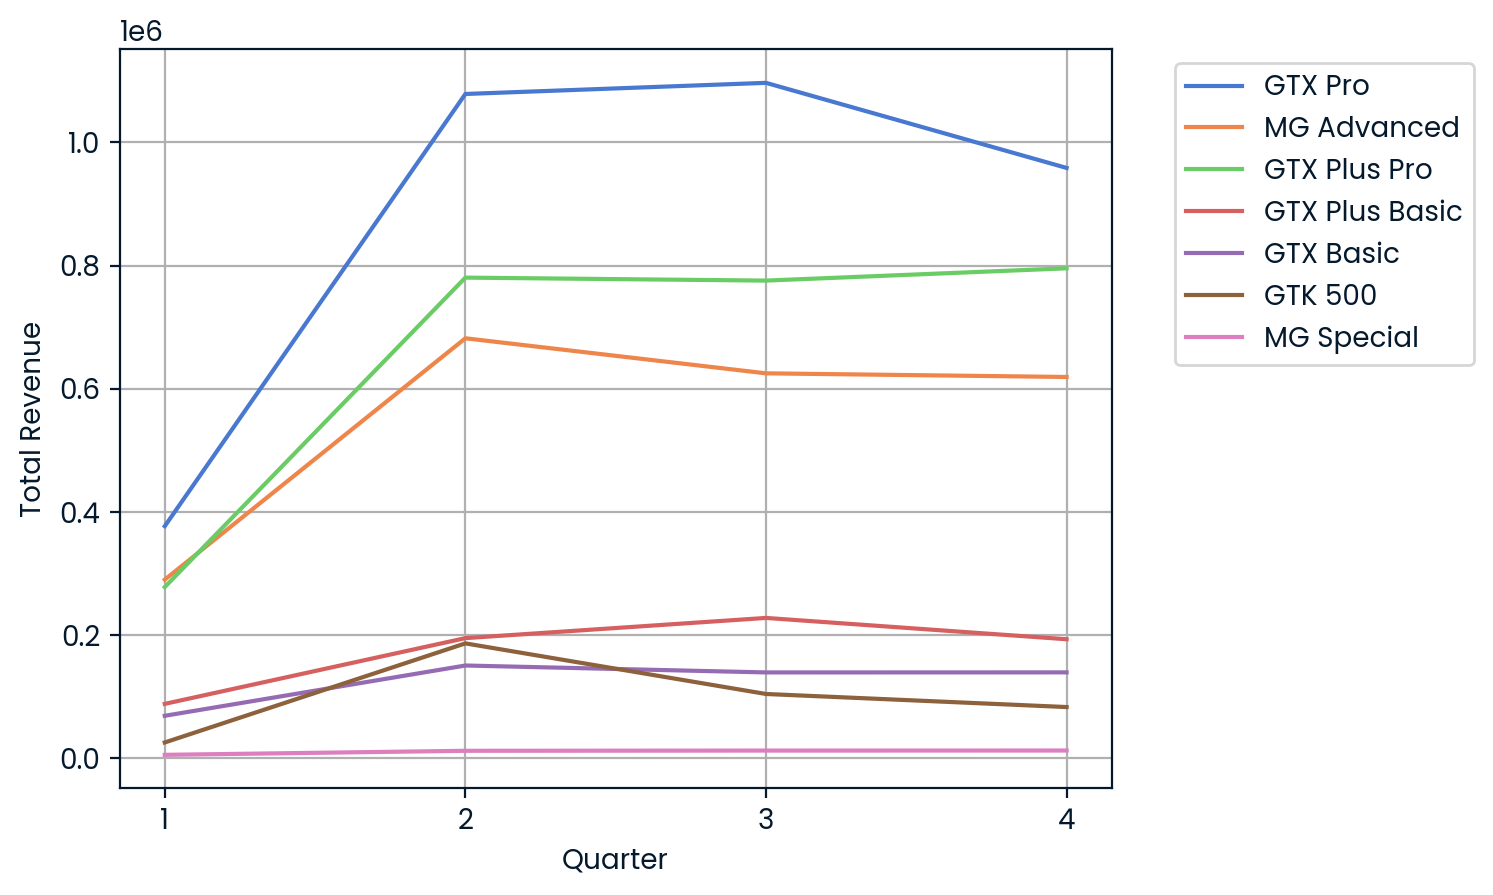

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
x = sns.lineplot(x=ProductStats["quarter"], y=ProductStats["total_revenue"], hue=ProductStats["product"], palette="muted")
x.legend (bbox_to_anchor = (1.05, 1))
x.set_xticks(range(1,5))
plt.xlabel("Quarter")
plt.ylabel("Total Revenue")
plt.grid(True)

Every quarter, **GTX Pro** was the top contributor to the total sales value, with **MG Advanced** and **GTX Plus Pro** variously in the 2nd and 3rd spot. Likewise, **MG Special** was consistently at the last place.

## SALES OVER TIME
In order to analyze the month-over-month trends in sales, I query for the total number of won/lost opportunities, total value of closed sales, and the difference between the current and previous month. The metrics are provided for each month.

The query results are visualized by using matplotlib.

In [43]:
SELECT 
	EXTRACT(YEAR from close_date) AS year,
	EXTRACT(MONTH from close_date) AS month,
	SUM(CASE WHEN deal_stage = 'Won' THEN 1 END) AS won,
	SUM(CASE WHEN deal_stage = 'Lost' THEN 1 END) AS lost,
	COUNT(opportunity_id) AS total_closed_opportunities,
	SUM(close_value) AS total_revenue,
	SUM(close_value) - LAG(total_revenue) OVER (ORDER BY month) AS vs_previous_month
FROM sales_pipeline.csv
WHERE close_date IS NOT null
GROUP BY year, month
ORDER BY month
-- the resulting table is saved to DataFrame "SalesOverTime"

,year,month,won,lost,total_closed_opportunities,total_revenue,vs_previous_month
0,2017,3,531.0,116.0,647,1134672.0,NaN
1,2017,4,285.0,301.0,586,721932.0,-412740.0
2,2017,5,438.0,367.0,805,1025713.0,303781.0
3,2017,6,531.0,110.0,641,1338466.0,312753.0
4,2017,7,308.0,319.0,627,696932.0,-641534.0
5,2017,8,446.0,339.0,785,1050059.0,353127.0
6,2017,9,503.0,132.0,635,1235264.0,185205.0
7,2017,10,279.0,287.0,566,731980.0,-503284.0
8,2017,11,406.0,362.0,768,938943.0,206963.0
9,2017,12,511.0,140.0,651,1131573.0,192630.0


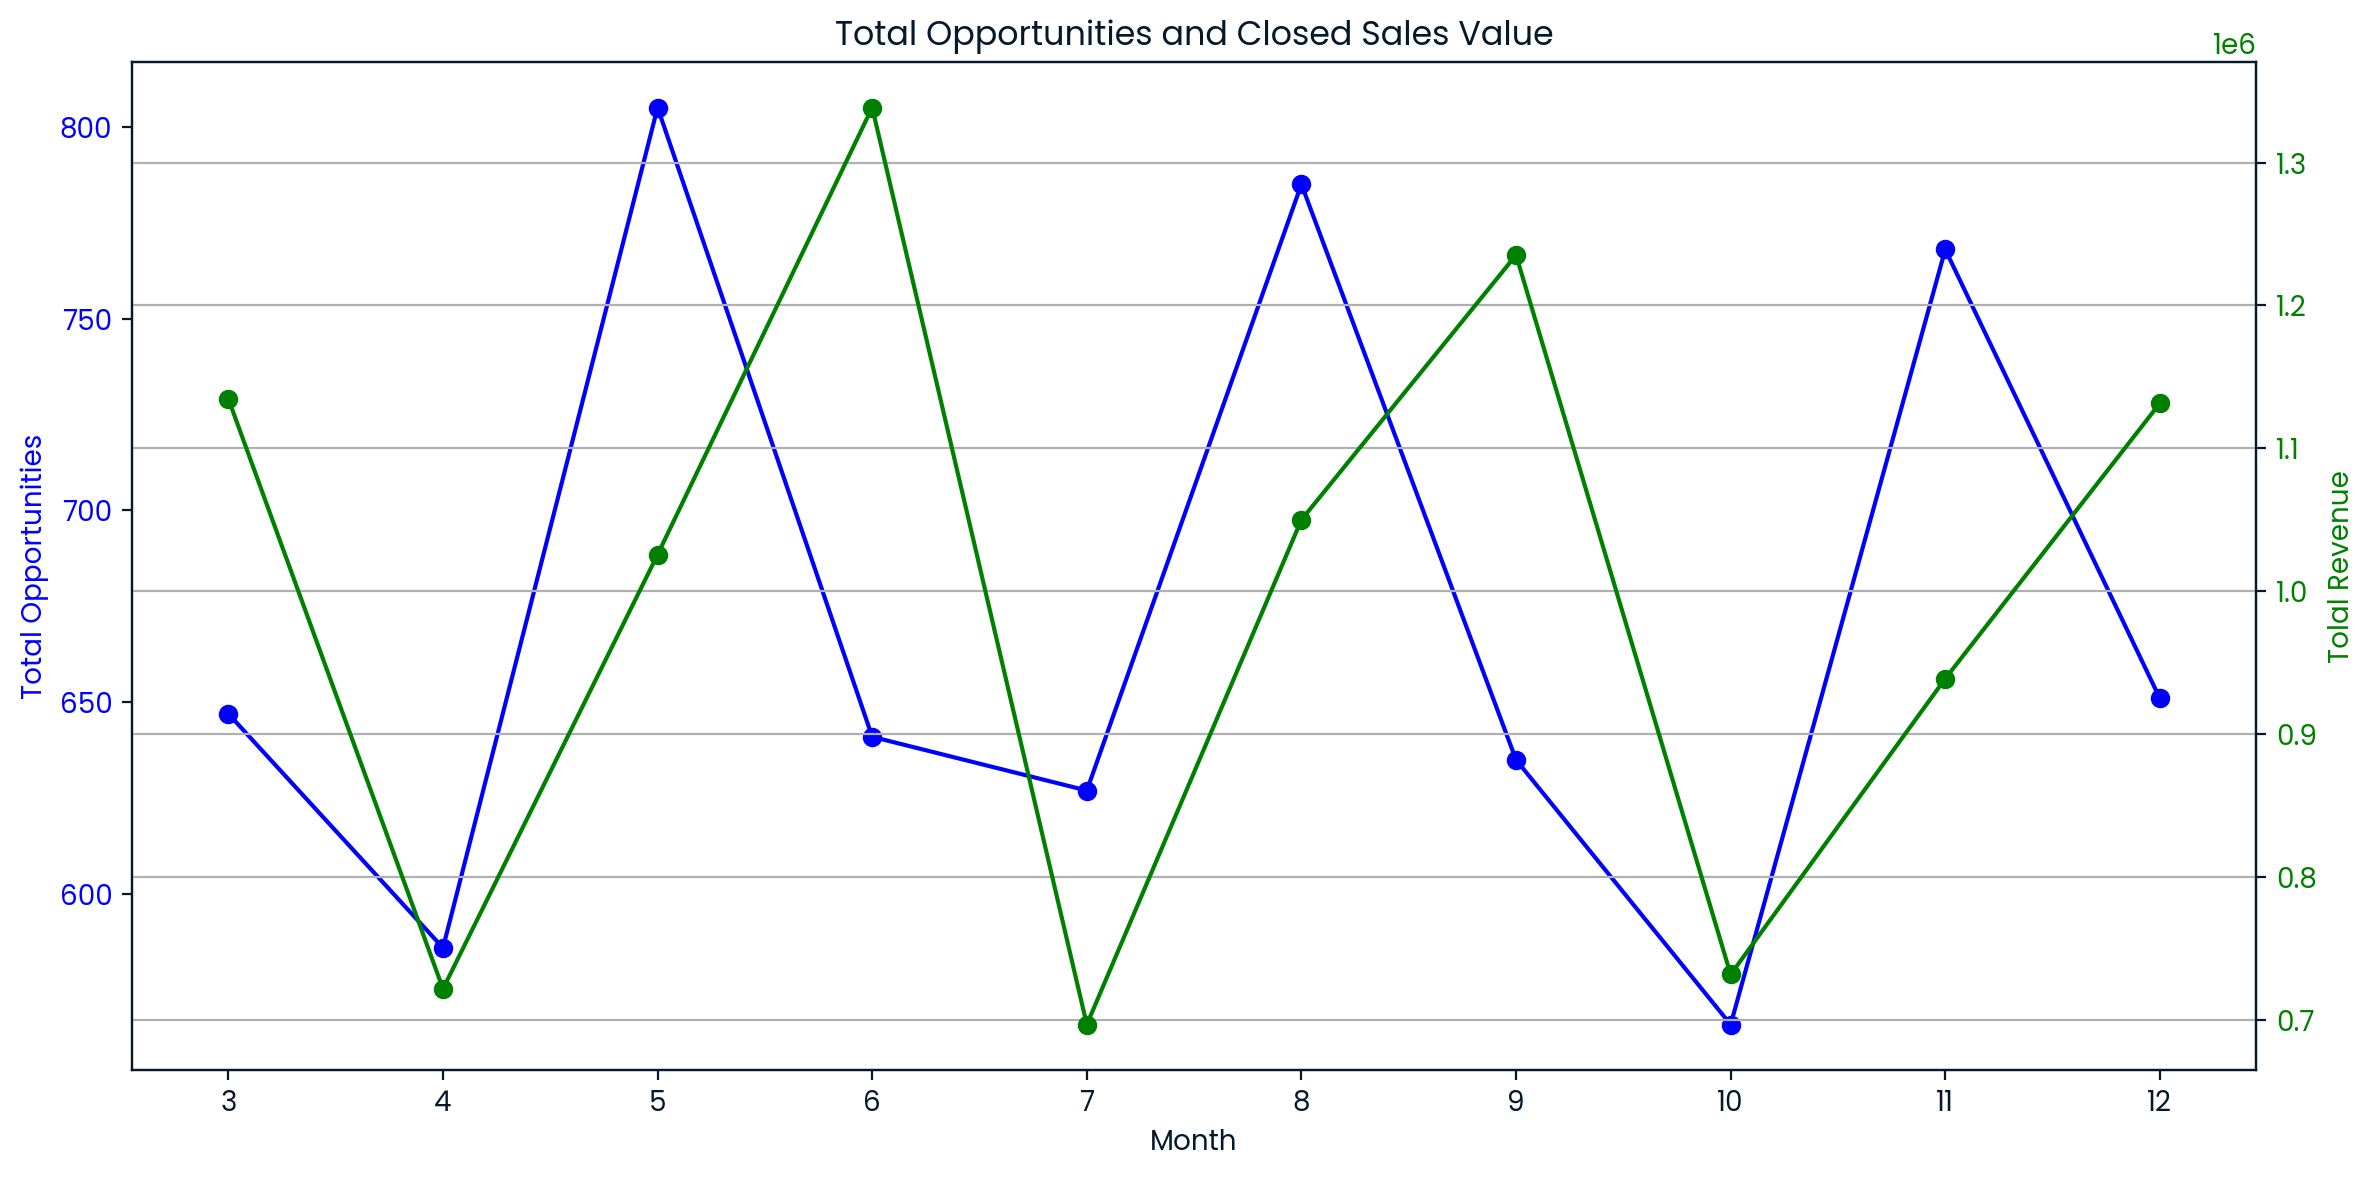

In [44]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))
plt.title('Total Opportunities and Closed Sales Value')

ax1.plot(SalesOverTime['month'], SalesOverTime['total_closed_opportunities'], label='Total Opportunities', marker='o', color='b')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Opportunities', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(range(1,13))

ax2 = ax1.twinx()
ax2.plot(SalesOverTime['month'], SalesOverTime['total_revenue'], label='Closed Sales Value', marker='o', color='g')
ax2.set_ylabel('Tolal Revenue', color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig.tight_layout()
plt.grid(True)
plt.show()

The total value of closed sales is periodical, with visible peaks in March, June, August and December.

## ACCOUNTS
To see the breakdown of revenue by customer sector and office location, I use two SQL queries:

In [45]:
SELECT
	a.sector, 
	SUM(sp.close_value) AS revenue,
	ROUND(SUM(sp.close_value) * 100 / SUM(SUM(sp.close_value)) OVER (),2) as percentage
FROM accounts.csv AS a
LEFT JOIN sales_pipeline.csv AS sp
ON a.account = sp.account
GROUP BY a.sector,
ORDER BY revenue DESC
LIMIT 10;

,sector,revenue,percentage
0,retail,1867528.0,18.66
1,technolgy,1515487.0,15.15
2,medical,1359595.0,13.59
3,software,1077934.0,10.77
4,finance,950908.0,9.50
5,marketing,922321.0,9.22
6,entertainment,689007.0,6.89
7,telecommunications,653574.0,6.53
8,services,533006.0,5.33
9,employment,436174.0,4.36


In [46]:
SELECT
	a.office_location, 
	SUM(sp.close_value) AS revenue,
	ROUND(SUM(sp.close_value) * 100 / SUM(SUM(sp.close_value)) OVER (),2) as percentage
FROM accounts.csv AS a
LEFT JOIN sales_pipeline.csv AS sp
ON a.account = sp.account
GROUP BY a.office_location,
ORDER BY revenue DESC
LIMIT 10;

,office_location,revenue,percentage
0,United States,8426955.0,84.22
1,Korea,194957.0,1.95
2,Jordan,163339.0,1.63
3,Panama,151777.0,1.52
4,Japan,123506.0,1.23
5,Belgium,117463.0,1.17
6,Norway,115712.0,1.16
7,Italy,114352.0,1.14
8,Kenya,107408.0,1.07
9,Poland,106754.0,1.07


Around 47.5% of revenue is generated by the retail, technology and medical sectors. Customers based in the United Stated are responsible for 84.2 % of total revenue.

## PERFORMANCE OF EACH SALES TEAM
In order to analyze the performance of each sales teams, I query for the total number of closed opportunities, win rate (as ratio of won cases to the total number of cases), total value of closed opportunities, and average value of opportunity. These metrics will be provided for each manager in each regional office.

The query results are visualized by using matplotlib.

In [47]:
SELECT 
	st.manager,
	st.regional_office,
	COUNT(DISTINCT sp.sales_agent) AS agents_in_team,
	COUNT(sp.close_date) AS closed_opportunities,
	ROUND(SUM(CASE WHEN sp.deal_stage = 'Won' THEN 1 END) / COUNT(sp.close_date),2) AS win_rate,
	SUM(sp.close_value) AS total_revenue,
	ROUND(AVG(sp.close_value),2) AS average_close_value
FROM sales_pipeline.csv AS sp
LEFT JOIN sales_teams.csv AS st
ON sp.sales_agent = st.sales_agent
GROUP BY st.manager, st.regional_office
ORDER BY total_revenue DESC;
-- the resulting table is saved to DataFrame "Teams"

,manager,regional_office,agents_in_team,closed_opportunities,win_rate,total_revenue,average_close_value
0,Melvin Marxen,Central,5,1418,0.62,2251930.0,1588.10
1,Summer Sewald,West,5,1287,0.64,1964750.0,1526.61
2,Rocco Neubert,East,5,1113,0.62,1960545.0,1761.50
3,Celia Rouche,West,5,962,0.63,1603897.0,1667.25
4,Cara Losch,East,5,745,0.64,1130049.0,1516.84
5,Dustin Brinkmann,Central,5,1186,0.63,1094363.0,922.73


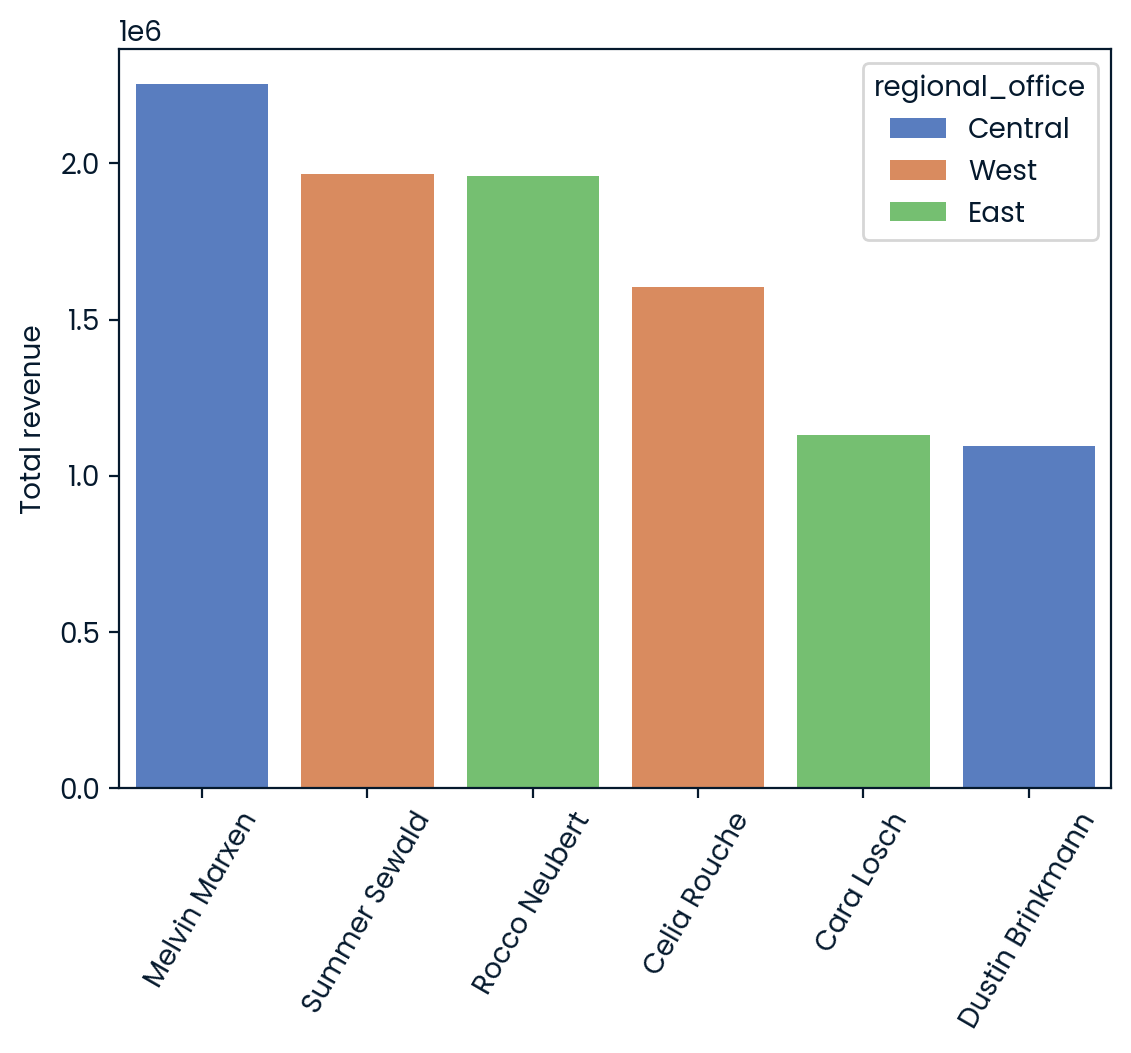

In [48]:
import seaborn as sns
g = sns.barplot(x=Teams["manager"],y=Teams["total_revenue"],hue=Teams["regional_office"],palette="muted")
plt.xlabel(None)
plt.ylabel("Total revenue")
g.tick_params(axis='x', labelrotation=60)

Despite all the teams having an equal number of agents (5), there is a strong discrepancy between the amount of opportunities among teams. Melvin Marxen boasts the highest number of opportunities at 1418, almost twice of Cara Losch's and Dustin Brinkmann's.

The win rate is consistent among the teams (62% - 64%).

The mean opportunity value for all teams is in the 1500-1700 range, with the single outlier being Dustin Brinkmann's team at 922.73.

## PERFORMANCE OF INDIVIDUAL SALES AGENTS
In order to analyze the performance of each sales agent, the previous query can be expanded by adding the sales_agent field. Additionally, the agents within each regional office were ranked using the DENSE_RANK() window function.

Based on the resulting table, a heatmap will be created using Python matplotlib.

In [49]:
SELECT 
	DENSE_RANK() OVER(ORDER BY SUM(sp.close_value) DESC) as overall_rank,
	DENSE_RANK() OVER(PARTITION BY st.regional_office ORDER BY SUM(sp.close_value) DESC) as rank_in_office,
	st.sales_agent,
	st.manager,
	st.regional_office,
	COUNT(sp.close_date) AS closed_opportunities,
	ROUND(SUM(CASE WHEN sp.deal_stage = 'Won' THEN 1 END) / COUNT(sp.close_date),2) AS win_rate,
	SUM(sp.close_value) AS total_revenue,
	ROUND(AVG(sp.close_value),2) AS average_close_value
FROM sales_pipeline.csv AS sp
LEFT JOIN sales_teams.csv AS st
ON sp.sales_agent = st.sales_agent
GROUP BY st.manager, st.regional_office, st.sales_agent
ORDER BY total_revenue DESC
-- the resulting table is saved to DataFrame "Agents"

,overall_rank,rank_in_office,sales_agent,manager,regional_office,closed_opportunities,win_rate,total_revenue,average_close_value
0,1,1,Darcel Schlecht,Melvin Marxen,Central,553,0.63,1153214.0,2085.38
1,2,1,Vicki Laflamme,Celia Rouche,West,347,0.64,478396.0,1378.66
2,3,2,Kary Hendrixson,Summer Sewald,West,335,0.62,454298.0,1356.11
3,4,1,Cassey Cress,Rocco Neubert,East,261,0.62,450489.0,1726.01
4,5,2,Donn Cantrell,Rocco Neubert,East,275,0.57,445860.0,1621.31
5,6,3,Reed Clapper,Rocco Neubert,East,237,0.65,438336.0,1849.52
6,7,3,Zane Levy,Summer Sewald,West,261,0.62,430068.0,1647.77
7,8,4,Corliss Cosme,Cara Losch,East,229,0.66,421036.0,1838.59
8,9,4,James Ascencio,Summer Sewald,West,206,0.66,413533.0,2007.44
9,10,5,Daniell Hammack,Rocco Neubert,East,187,0.61,364229.0,1947.75


Defaulting to user installation because normal site-packages is not writeable


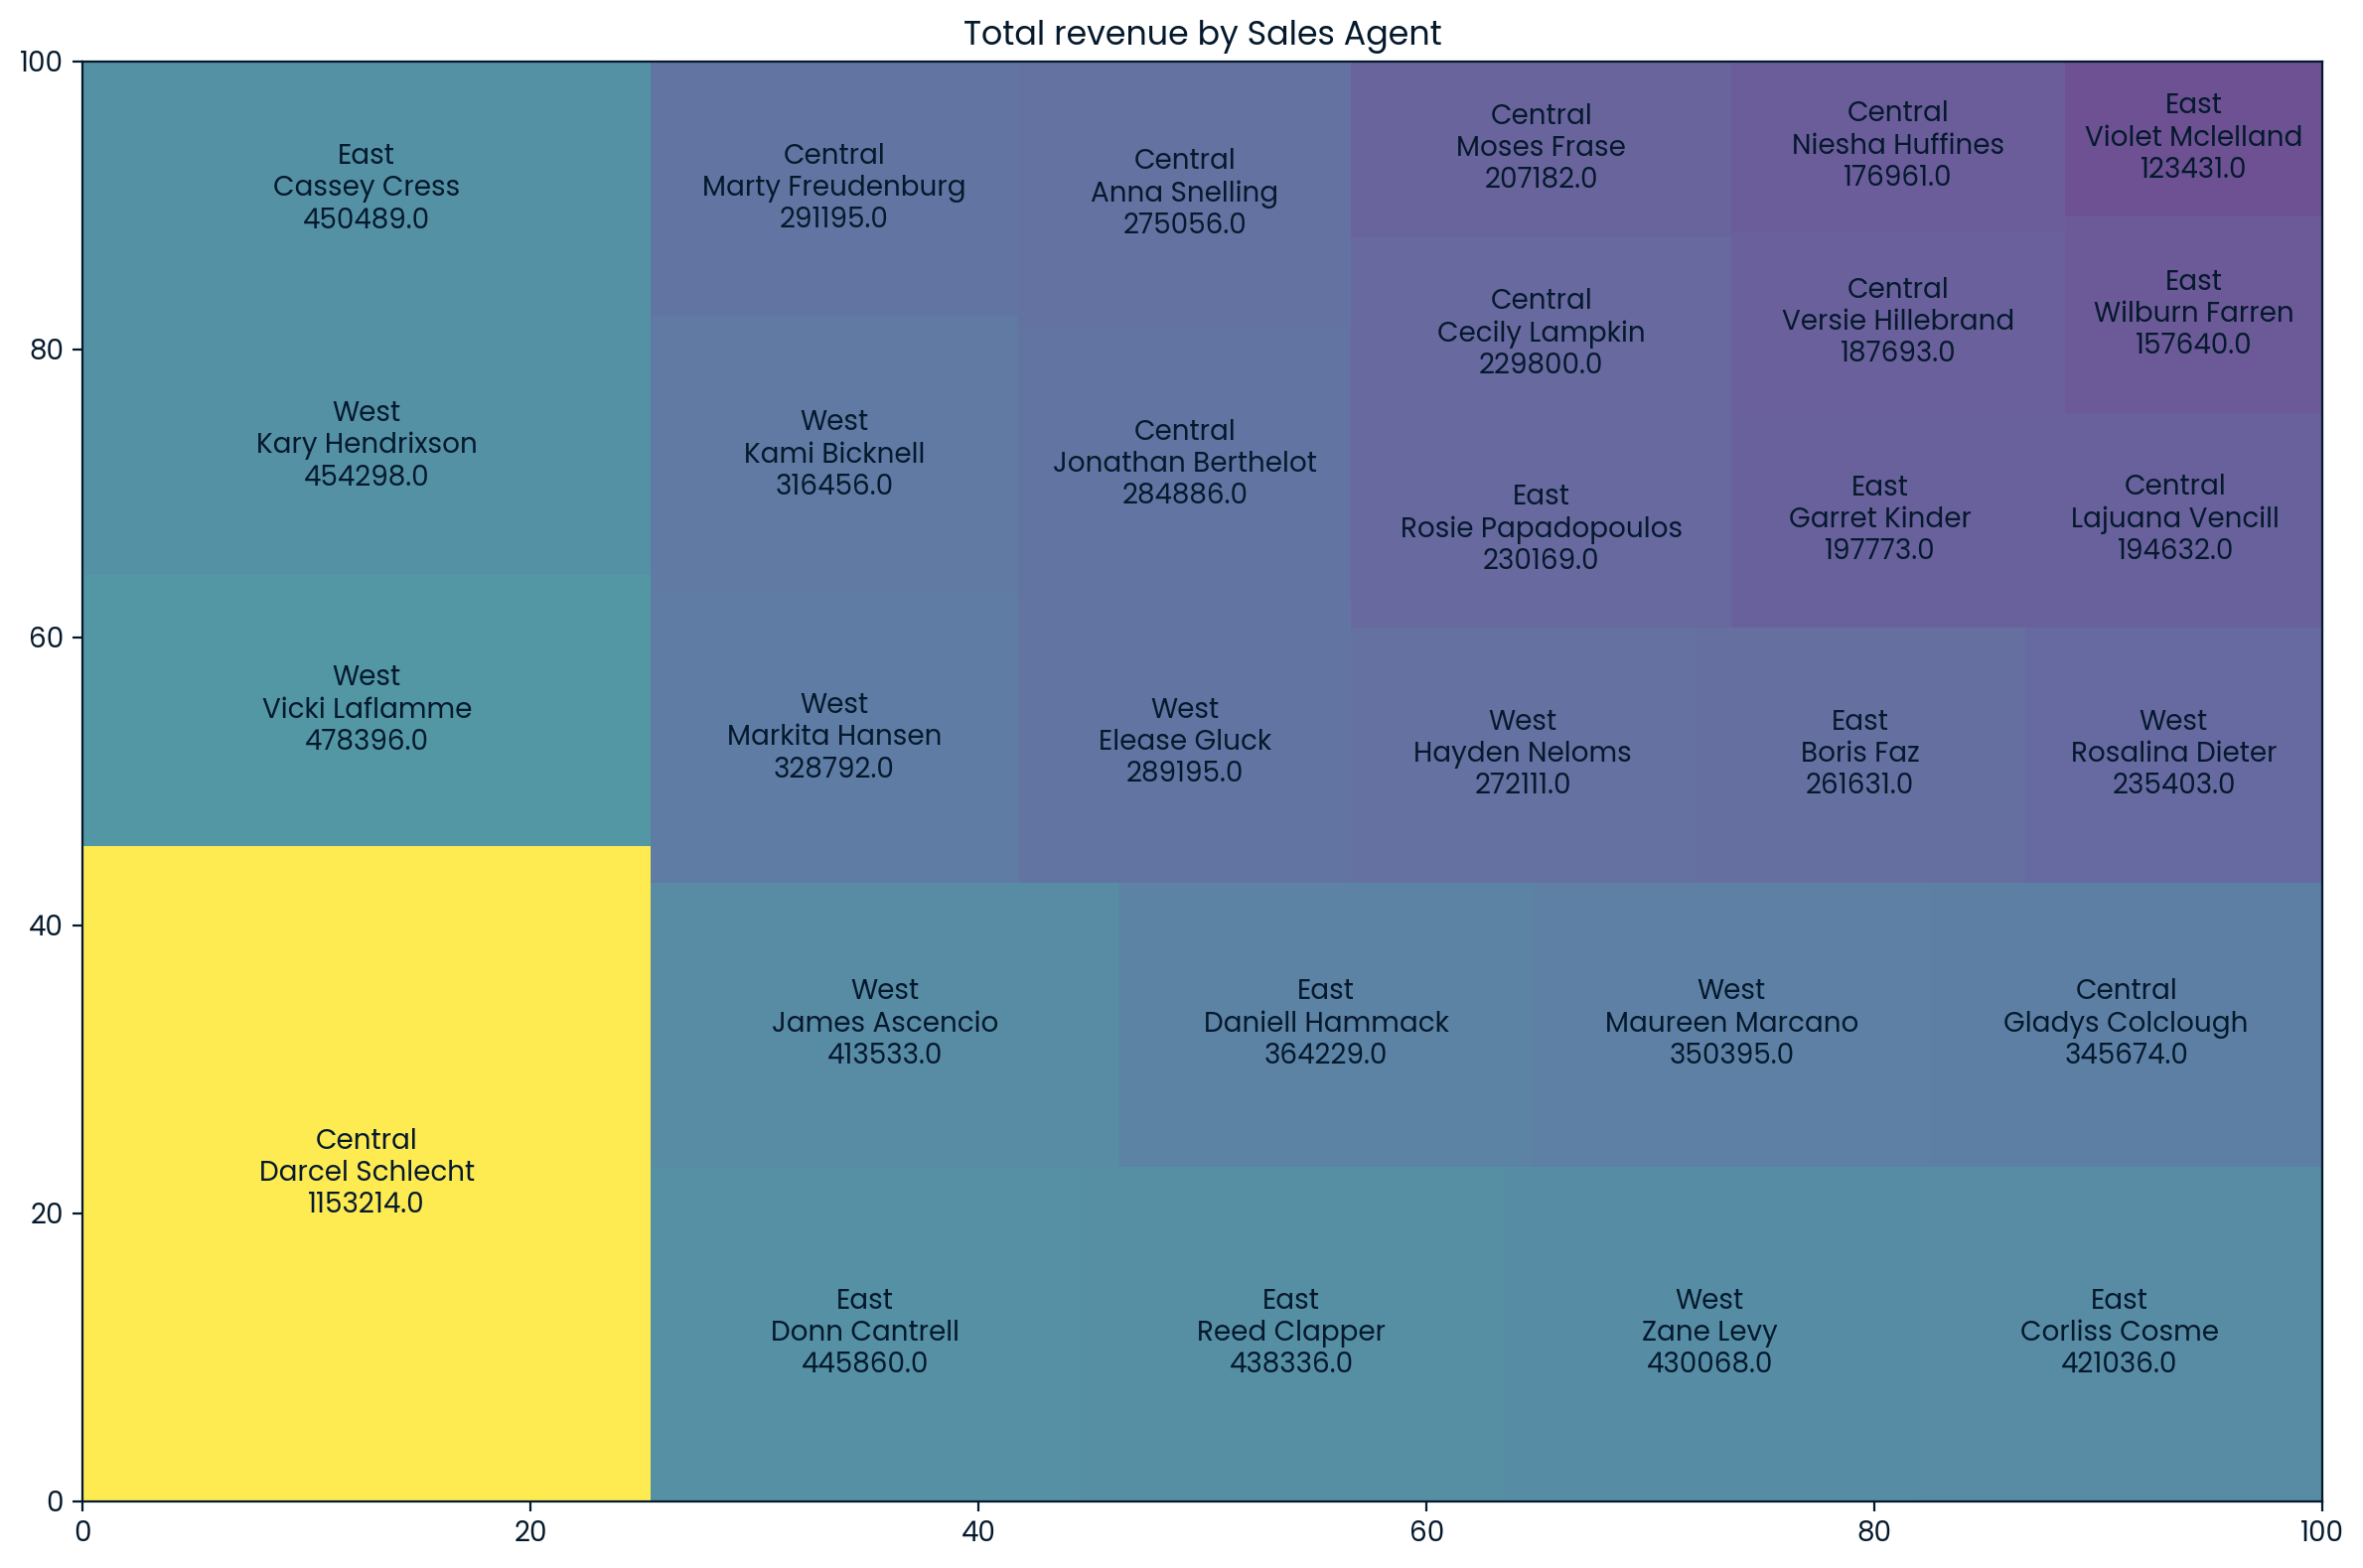

In [50]:
!pip install squarify
import matplotlib.pyplot as plt
import squarify

labels = Agents['regional_office'] + "\n" + Agents['sales_agent'] + "\n" + Agents['total_revenue'].astype(str)
sizes = Agents['total_revenue']
colors = plt.cm.viridis(sizes / max(sizes))

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)
plt.title('Total revenue by Sales Agent')
plt.tight_layout()

### Highest revenue agent
The by far highest total revenue belongs to sales agent Darcel Schlecht from Melvin Marxen's team, at 1 153 214, over two times above the second place (Vicki Laflamme's 478 396). Unsurprisingly, Darcel Schlecht also amassed the highest number of closed sales at 553. This is a likely explanation to the success of Melvin Marxen's sales team. 

This warrants further investigation. A query with a common table expression can be used to compare Darcel Schlecht's results with the average for all agents:

In [51]:
WITH cte AS (
    SELECT 
        st.sales_agent,
        COUNT(sp.close_date) AS closed_opportunities,
        ROUND(SUM(CASE WHEN sp.deal_stage = 'Won' THEN 1 ELSE 0 END) / COUNT(sp.close_date), 2) AS win_rate,
        SUM(sp.close_value) AS total_close_value,
        ROUND(AVG(sp.close_value), 2) AS average_value
    FROM sales_pipeline.csv AS sp
    LEFT JOIN sales_teams.csv AS st
    ON sp.sales_agent = st.sales_agent
    GROUP BY st.manager, st.regional_office, st.sales_agent
)

SELECT 
    'mean for all agents' AS value,
    ROUND(AVG(win_rate),2) AS win_rate, 
    ROUND(AVG(closed_opportunities),0) AS closed_opportunities, 
    ROUND(AVG(total_close_value),0) AS close_value, 
    ROUND(AVG(average_value),2) AS average_value
FROM cte
UNION ALL
SELECT
	'Darcel Schlecht' as value,
	win_rate,
	closed_opportunities,
	total_close_value,
	average_value
FROM cte
WHERE sales_agent = 'Darcel Schlecht';

,value,win_rate,closed_opportunities,close_value,average_value
0,mean for all agents,0.63,224.0,333518.0,1524.94
1,Darcel Schlecht,0.63,553.0,1153214.0,2085.38


While the win rate is perfectly average, the other three metrics are far above the average.

Lastly, let's check if there is a customer sector or a product type that Darcel Schlecht specializes in:

In [52]:
SELECT a.sector, p.product, SUM(close_value) AS revenue, COUNT(DISTINCT sp.opportunity_id) AS opportunities
FROM sales_pipeline.csv AS sp
JOIN accounts.csv AS a
ON a.account = sp.account
JOIN products.csv AS p
ON p.product = sp.product
WHERE sales_agent = 'Darcel Schlecht' AND close_value IS NOT null
GROUP BY a.sector, p.product
ORDER BY revenue DESC
LIMIT 10;

,sector,product,revenue,opportunities
0,medical,GTX Plus Pro,36442.0,9
1,marketing,GTX Plus Pro,33921.0,10
2,technolgy,MG Advanced,26192.0,13
3,finance,GTX Plus Pro,25156.0,6
4,medical,MG Advanced,23946.0,11
5,software,MG Advanced,19588.0,9
6,retail,GTX Plus Pro,17025.0,6
7,retail,MG Advanced,16672.0,7
8,technolgy,GTX Plus Pro,16426.0,6
9,software,GTX Plus Pro,14549.0,3


There seem to be no obvious outliers. Product-wise, only **GTX Plus Pro** and **MG Advanced** appear, the 2nd and  globally most profitable products. Curiously, the GTX Pro, which generated the most overall revenue, is absent from the top 10. The 6 sectors are also the six globally most profitable ones. 

## SUMMARY
Using PostgreSQL queries and Python visualization tools, I have explored the dataset, identifying:
- the structure of the data tables,
- the best performing products,
- the amount of opportunities and revenue over time,
- the customers, discovering which sectors (and in which countries) generate the most of the revenue,
- the performance of each sales team,
- the performance of individual agents with each team, 
- and the activities of the most successful agent.